In [1]:
import torch
import torch.nn as nn
from torch import optim
import numpy as np
import visdom
import random

In [2]:
batch_size = 512

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.SiLU(),
            nn.Linear(50, 60),
            nn.SiLU(),
            nn.Linear(60, 40),
            nn.SiLU(),
            nn.Linear(40, 2),
        )

    def forward(self, x):
        output = self.net(x)
        return output

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.SiLU(),
            nn.Linear(50, 60),
            nn.SiLU(),
            nn.Linear(60, 40),
            nn.SiLU(),
            nn.Linear(40, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x).view(-1)

In [3]:
def data_generator():
    """
    8- gaussion mixture models
    :return:
    """
    scale = 2
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1. / np.sqrt(2), 1. / np.sqrt(2)),
        (1. / np.sqrt(2), -1. / np.sqrt(2)),
        (-1. / np.sqrt(2), 1. / np.sqrt(2)),
        (-1. / np.sqrt(2), -1. / np.sqrt(2)),
    ]
    centers = [(scale * x, scale * y ) for x, y in centers]
    while True:
        dataset = []

        for i in range(batch_size):
            point = np.random.randn(2) * 0.02
            center = random.choice(centers)
            point[0] += center[0]
            point[1] += center[1]
            dataset.append(point)
        dataset = np.array(dataset).astype(np.float32)
        dataset /= 1.414
        yield dataset

In [4]:
viz = visdom.Visdom()
viz.scatter(next(data_generator()), win = 'real')

Setting up a new session...


'real'

In [12]:
torch.manual_seed(23)
np.random.seed(23)

data_iter = data_generator()
x = next(data_iter)

G = Generator().cuda()
D = Discriminator().cuda()
optimizer_G = optim.Adam(G.parameters(), lr = 0.003, betas = (0.5, 0.9))
optimizer_D = optim.Adam(D.parameters(), lr = 0.003, betas = (0.5, 0.9))
while True:
    epoch += 1
    
    # train discriminator firstly
    for _ in range(65):
        # 1.1 train on real data
        x_real = next(data_iter)
        x_real = torch.from_numpy(x_real).cuda()
        pred_real = D(x_real)
        # real data: max_possibilty
        loss_real = - pred_real.mean()
        # 1.2 train on fake data
        z = torch.randn(batch_size, 2).cuda()
        x_fake = G(z).detach() # 类似于 stop_gradient()
        pred_fake = D(x_fake)
        loss_fake = pred_fake.mean()

        loss_D = loss_fake + loss_real
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

    # train generator
    for _ in range(4):
        z = torch.randn(batch_size, 2).cuda()
        x_fake = G(z)
        pred_fake = D(x_fake)
        loss_G = - pred_fake.mean()
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()
        viz.scatter(x_fake, win = 'data')


    viz.line([[loss_D.item()],[loss_G.item()]],
             [epoch], 
             win = 'line',
             update = 'append',
             opts = dict(legend = ['D', 'G']))

KeyboardInterrupt: 

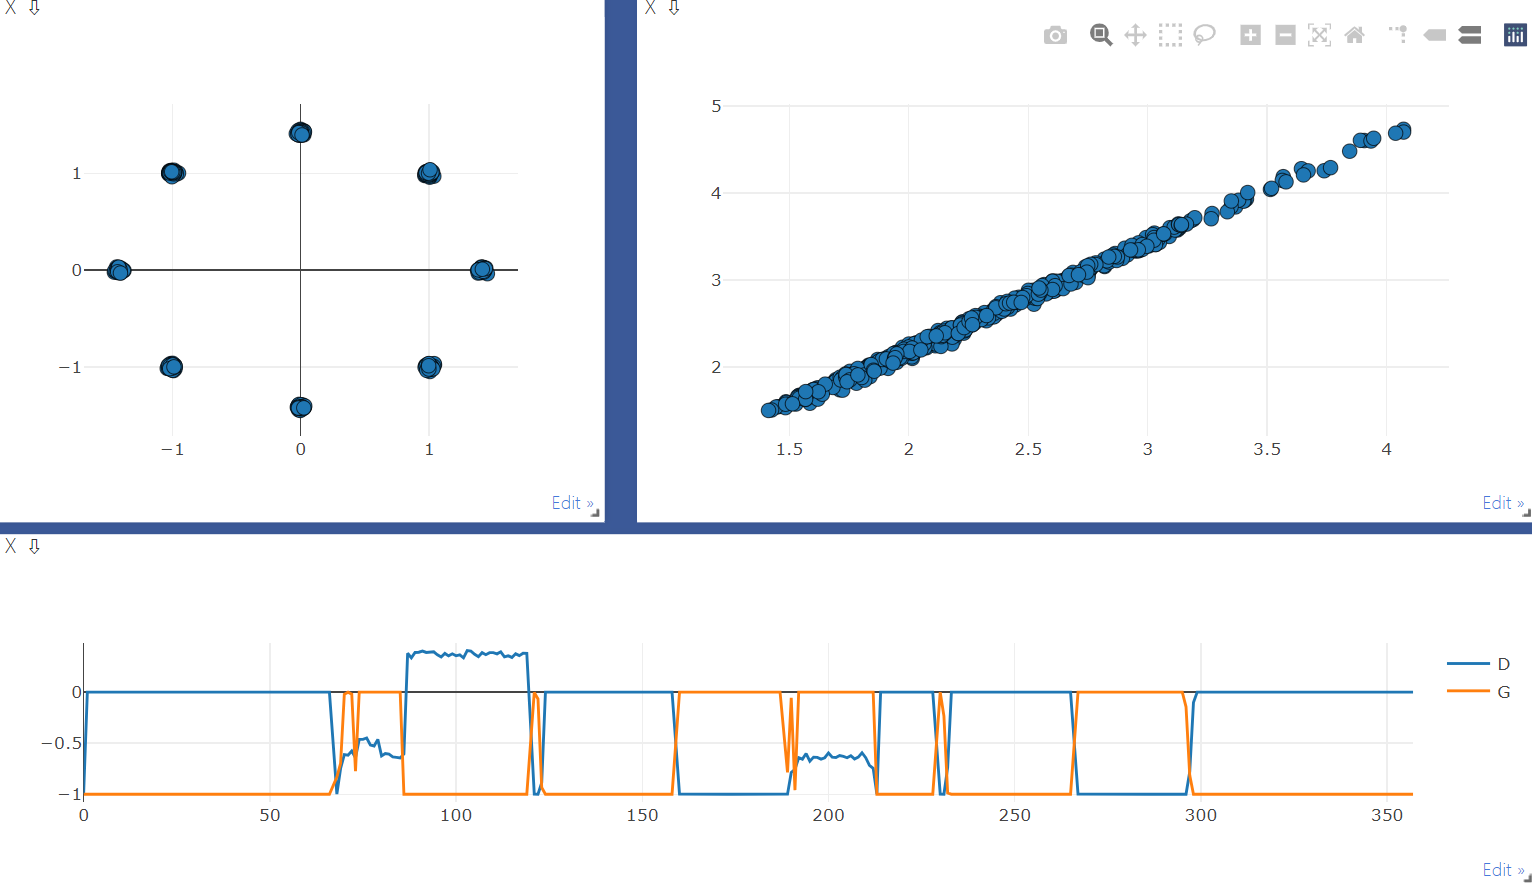

##### 别人的GAN: 神仙打架, 交替上升
##### 我的GAN: 菜鸡互啄+ 一只鸡被另一只鸡全面碾压